# Dynamic parallel tasks with Send API

* Exact edges are not known at design time
* The number of parallel tasks is determined by a state attribute.
* Invoked in a regular node or via conditional edge
* May need different state for nodes i.e., the parent & workers may have different state schema
* Schema for subtasks may be different from parent's schema; differentiates from conditional edges where the schema stays the same
* If different schema is used then a shared key with Annotated types are used for value transfer between parent/child
* Number & direction of edges may not be known in advance
* A dotted line represents the conditional edge in the visualization
* You need to create a List[] or workers with Send(..) and pass it to the conditional edge

### Worker-orchestrator pattern
https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#orchestrator-worker

### Send API
https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send

The **Send** API can also be used for creating dynamic parallel graphs.
* Send takes the node and state for the task



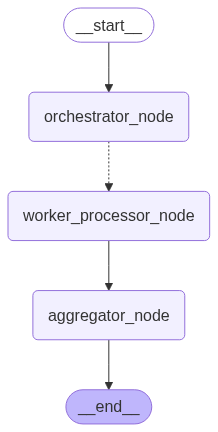

Processor#1 range: (0, 10)  generated: 6
Processor#2 range: (10, 20)  generated: 13
Processor#3 range: (20, 30)  generated: 24
Processor#4 range: (30, 40)  generated: 35
Processor#5 range: (40, 50)  generated: 41


{'num_workers': 5, 'total': 119, 'numbers': [6, 13, 24, 35, 41]}

In [3]:
## 1. The graph dynamically spawns N workers (configurable via num_workers in the input state)
## 2. Each worker is assigned: A unique name AND a numeric range for random number generation (e.g., (0, 10), (10, 20), etc.).
## 3. Each worker: 
##    Generates a random integer R within its assigned range
##    Appends R to a shared list (numbers) in the global state
## 4. State of parent graph = {num_workers, numbers, sum of random_numbers}
## 5. State of worker nodes = {range, name, numbers} 
##    Shared key between parent & workers = numbers

## References
### [Parallelization](https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#parallelization)
### [Send Class](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send)
### [Worker orchestrator pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#orchestrator-worker)
### [Add conditional edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.add_conditional_edges)

# Import the required libraries
from langgraph.graph import StateGraph, START, END
from typing import List, Annotated, TypedDict
from langgraph.types import Send
from IPython.display import Image, display
import random
import operator

# Parent graph state
class StateParent(TypedDict):
    num_workers: int
    total: int
    numbers: Annotated[list, operator.add]  # Shared key between workers & parent

# Worker State : Instance shared by all workers
class StateWorker(TypedDict):
    name: str
    range: tuple[int, int]
    numbers: Annotated[list, operator.add]  # Shared key between workers & parent

# Node: Initializes the graph's state
def orchestrator_node(state: StateParent):
    # Initialize the state 
    return {"numbers": [], "total": 0}

# Node: Returns the 'common key' numbers
def worker_processor_node(state: StateWorker)->StateWorker:
    lower, upper = state["range"]
    rint = random.randint(lower, upper)
    print(f"{state["name"]} range: ({lower}, {upper})  generated: {rint}")
    return {"numbers": [rint]}

# Node : The shared key numbers is taken care in this node
def aggregator_node(state: StateParent)->StateParent:
    nums = state["numbers"]
    return {"total": sum(nums)}

# Router logic - Worker creation : used from conditional edge
def assign_workers(state: StateParent)->StateParent:
    # Get the number of workers to be created
    num_workers = state["num_workers"]

    # List of Send instances to be returned
    workers = []
    for num in range(num_workers):
        worker_args = {
            "name" : f"Processor#{num+1}",
            "range": (num*10, (num*10)+10)
        }
        workers.append(Send("worker_processor_node", worker_args))
        
    return workers

# Graph
parallel_graph = StateGraph(StateParent)

# Add nodes
parallel_graph.add_node("orchestrator_node", orchestrator_node)
parallel_graph.add_node("worker_processor_node", worker_processor_node)
parallel_graph.add_node("aggregator_node", aggregator_node)

# Add edges
parallel_graph.add_edge(START,"orchestrator_node")

# Ad conditional edgse : Spawns multiple workers dynamically
# list passed as a path_map simply means key/value are same
parallel_graph.add_conditional_edges(
                                        "orchestrator_node",
                                        assign_workers,
                                        ["worker_processor_node"]
)
parallel_graph.add_edge("worker_processor_node","aggregator_node")
parallel_graph.add_edge("aggregator_node",END)

# Compile
parallel_graph_compiled = parallel_graph.compile()

# Display
display(Image(parallel_graph_compiled.get_graph().draw_mermaid_png()))

# # Invoke
parallel_graph_compiled.invoke({"num_workers": 5})

## Map-Reduce
This example transforms the output from the worker nodes in the reducer node.

* The graph spawns N tasks (processors) at runtime, where N = state["tasks"] (configurable on invocation).
* Each task (processor) receives: A unique name (passed via state["name"] in TaskState) AND generates a random integer between 1 and 10.
* Each task (processor node): Generates a random integer R (1 ≤ R ≤ 10). AND Returns R and its name in annotated lists
* The reduce_node:
   -  Receives merged state with all rint and name values AND Transforms data into a structured result list
   -  Computes the total (sum of all rint values).
   -  Returns final state


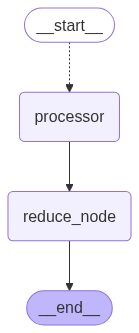

Task started: task-0
Task started: task-1
Task started: task-2
Task started: task-3
Task started: task-4
Reducer received : {'rint': [4, 3, 1, 2, 7], 'name': ['task-0', 'task-1', 'task-2', 'task-3', 'task-4']}


{'tasks': 5,
 'total': 17,
 'result': [{'name': 'task-0', 'rint': 4},
  {'name': 'task-1', 'rint': 3},
  {'name': 'task-2', 'rint': 1},
  {'name': 'task-3', 'rint': 2},
  {'name': 'task-4', 'rint': 7}]}

In [5]:
from langgraph.types import Send
from langgraph.graph import StateGraph, START, END
from typing import List, Annotated, TypedDict
from IPython.display import Image, display
import random
import operator
   

class StateParallelSend(TypedDict):
    tasks: int
    total: int
    result: dict

# Attributes must be annotated as multiple tasks will be updating the state
class TaskState(TypedDict):
    rint: Annotated[list[int], operator.add]
    name: Annotated[list[str], operator.add]
    
def processor(state: TaskState):
    print(f"Task started: {state["name"]}")
    # print(f"message from {state["name"]}")
    rint = random.randint(1, 10)
    return {"rint": [rint], "name": [state["name"]]}

# Router logic
def map_node(state: StateParallelSend):
    sends = []
    for i in range(state["tasks"]):
        name = f"task-{i}"
        sends.append(Send("processor", {"name": name} ))
    return sends

def reduce_node(state: TaskState):
    print(f"Reducer received : {state}")

    # transform the received results from processors
    result = []
    total = 0
    for i in range(len(state["name"])):
        result.append({"name": state["name"][i], "rint": state["rint"][i]})
        total += state["rint"][i]
    return {"total": total, "result": result}

workflow_map_reduce = StateGraph(StateParallelSend)

workflow_map_reduce.add_node("processor",processor)

# add reduce node
workflow_map_reduce.add_node("reduce_node",reduce_node)

# map_node = router logic
workflow_map_reduce.add_conditional_edges(START, map_node,["processor"])

# add edge to reducer node
workflow_map_reduce.add_edge("processor", "reduce_node")

workflow_map_reduce_compiled = workflow_map_reduce.compile()

display(Image(workflow_map_reduce_compiled.get_graph().draw_mermaid_png()))

workflow_map_reduce_compiled.invoke({"tasks": 5})